In [1]:
#COMET ML API KEY YarDlAXZLHepLKBFlSPyWbDPt
import comet_ml
comet_ml.config.save(api_key="YarDlAXZLHepLKBFlSPyWbDPt")
from comet_ml import Experiment
experiment = Experiment(
    api_key="YarDlAXZLHepLKBFlSPyWbDPt",
    project_name="atp-contiguous-classification-with-interpolation",
    workspace="mattbeze",
    auto_metric_logging=True,
    auto_param_logging=True,
    auto_histogram_weight_logging=True,
    auto_histogram_gradient_logging=True,
    auto_histogram_activation_logging=True,
)

Saving config to "C:\Users\mattbeze\.comet.config"... done!


COMET INFO: Experiment is live on comet.ml https://www.comet.ml/mattbeze/atp-contiguous-classification-with-interpolation/cfb0b0d73ed542f99805cf1eacdf4f5b



In [2]:
import numpy as np
import seaborn as sn
from imblearn.over_sampling import SMOTE 
import keras
from keras.utils import np_utils
from keras.layers import Input, Dense, Dropout
from keras.models import Model
from keras import losses
from keras.datasets import mnist
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.utils import class_weight
from sklearn.metrics import recall_score, confusion_matrix, multilabel_confusion_matrix, precision_score, precision_recall_curve, average_precision_score
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split, GridSearchCV
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from pandas import DataFrame
import xlsxwriter
import time

seed_value = 7
import os
os.environ['PYTHONHASHSEED']=str(seed_value)
import random
random.seed(seed_value)
import numpy as np
np.random.seed(seed_value)
import tensorflow as tf
tf.random.set_seed(seed_value)
#Extra features that are available: Sex, Gestational Age 

#22 1s Atypicals defined as having an attention problem t-score >= 65 in BASC2 6year
#115 0s

Using TensorFlow backend.


In [3]:
Training_Data = pd.ExcelFile("Scaled_Gilmore_Data_CT_SA_1_2.xlsx") #Training Data already pre-scaled to the IBIS Data set
Label_Data = pd.ExcelFile("Labels.xlsx") #Labels
data = Training_Data.parse(Training_Data.sheet_names[0])
label_data = Label_Data.parse(Label_Data.sheet_names[0])
data_features = data.loc[:, data.columns]
data_features = data_features.drop(['ROI','MATCH','INDEX','MATCH2','INDEX2', 'ATP', 'HYP', 'ATP Middle', 'HYP Middle', 'HYP Label'], axis=1)
data_features = data_features.dropna()
data_features = data_features.drop(['ATP Label'], axis=1)
labels = label_data.loc[:, label_data.columns]
labels = labels.drop(['ROI','ATP Middle', 'HYP Middle', 'HYP Label'], axis=1)
labels = labels.dropna()
print(data_features.shape)
print(labels.shape)

(137, 298)
(137, 1)


In [4]:
interpolated_data = Training_Data.parse(Training_Data.sheet_names[8])
interpolated_data_features = interpolated_data.loc[:, interpolated_data.columns]
interpolated_data_features = interpolated_data_features.drop(['ROI','MATCH','INDEX','MATCH2','INDEX2', 'ATP', 'HYP', 'ATP Label', 'HYP Middle', 'HYP Label'], axis=1)
interpolated_data_features = interpolated_data_features.dropna()
interpolated_data_features = interpolated_data_features.drop(['ATP Middle'], axis=1)

interpolated_label_data = Label_Data.parse(Label_Data.sheet_names[1])
interpolated_labels = interpolated_label_data.loc[:, interpolated_label_data.columns]
interpolated_labels = interpolated_labels.drop(['ROI','ATP Label', 'HYP Middle', 'HYP Label'], axis=1)
interpolated_labels = interpolated_labels.dropna()

print(interpolated_data_features.shape)
print(interpolated_labels.shape)

(33, 298)
(33, 1)


In [5]:
data_features = data_features.to_numpy()
labels = labels.to_numpy()

interpolated_data_features = interpolated_data_features.to_numpy()
interpolated_labels = interpolated_labels.to_numpy()
interpolated_labels = interpolated_labels.flatten()

skf = StratifiedKFold(n_splits=8, random_state=seed_value)
skf.get_n_splits(data_features, labels)
print(skf)

training_folds_X = []
testing_folds_X = []
training_folds_Y = []
testing_folds_Y = []

for train_index, test_index in skf.split(data_features, labels):
  
    X_train, X_test = data_features[train_index], data_features[test_index]
    Y_train, Y_test = labels[train_index], labels[test_index]
   
    sm = SMOTE(sampling_strategy = 'minority', random_state = seed_value, k_neighbors=2) 
    X_train_smoted, Y_train_smoted = sm.fit_sample(X_train, Y_train) #Only smote the training set.
    X_train_complete = np.concatenate([X_train_smoted,interpolated_data_features])
    Y_train_complete = np.concatenate([Y_train_smoted,interpolated_labels])
    training_folds_X.append(X_train_smoted)
    testing_folds_X.append(X_test)
    training_folds_Y.append(Y_train_smoted)
    testing_folds_Y.append(Y_test)


StratifiedKFold(n_splits=8, random_state=7, shuffle=False)


C:\Users\mattbeze\Anaconda3\envs\tensorflow_env\lib\site-packages\sklearn\model_selection\_split.py:297: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


In [6]:
def create_summary_matrix(p0, p1, p2, p3, p4, p5, p6, p7, t0, t1, t2, t3, t4, t5, t6, t7):
    predictions = []
    true = []
    
    for i in range(0,p0.size):
        if p0[i] == 0:
            predictions.append(0)
        if p0[i] == 1:
            predictions.append(1)
        if t0[i] == 0:
            true.append(0)
        if t0[i] == 1:
            true.append(1)
    for i in range(0,p1.size):
        if p1[i] == 0:
            predictions.append(0)
        if p1[i] == 1:
            predictions.append(1)
        if t1[i] == 0:
            true.append(0)
        if t1[i] == 1:
            true.append(1)
    for i in range(0,p2.size):
        if p2[i] == 0:
            predictions.append(0)
        if p2[i] == 1:
            predictions.append(1)
        if t2[i] == 0:
            true.append(0)
        if t2[i] == 1:
            true.append(1)
    for i in range(0,p3.size):
        if p3[i] == 0:
            predictions.append(0)
        if p3[i] == 1:
            predictions.append(1)
        if t3[i] == 0:
            true.append(0)
        if t3[i] == 1:
            true.append(1)
    for i in range(0,p4.size):
        if p4[i] == 0:
            predictions.append(0)
        if p4[i] == 1:
            predictions.append(1)
        if t4[i] == 0:
            true.append(0)
        if t4[i] == 1:
            true.append(1)
    for i in range(0,p5.size):
        if p5[i] == 0:
            predictions.append(0)
        if p5[i] == 1:
            predictions.append(1)
        if t5[i] == 0:
            true.append(0)
        if t5[i] == 1:
            true.append(1)
    for i in range(0,p6.size):
        if p6[i] == 0:
            predictions.append(0)
        if p6[i] == 1:
            predictions.append(1)
        if t6[i] == 0:
            true.append(0)
        if t6[i] == 1:
            true.append(1)
    for i in range(0,p7.size):
        if p7[i] == 0:
            predictions.append(0)
        if p7[i] == 1:
            predictions.append(1)
        if t7[i] == 0:
            true.append(0)
        if t7[i] == 1:
            true.append(1)
    
    
    prec_score = precision_score(true, predictions, average=None)
    print('Positive Predictive Value tp/(tp+fp): ',prec_score[1])
    
    rec_score = recall_score(true, predictions, average=None)
    print('Recall Value tp/(tp+fn): ',rec_score[1])
    
    cf_matrix = confusion_matrix(true, predictions)
    print(cf_matrix)
    sn.heatmap(cf_matrix, annot=True)
    

In [7]:
#Best: 0.508814 using {'batch_size': 35, 'dropout': 0.15, 'epochs': 35, 'layer1_size': 100, 'layer2_size': 15}
def run_model(n):
    predictor = keras.models.load_model('ASD Pre_Trained Model for ATP Contiguous') #Model with ASD Pre-training

    class_weights={0:1, 1:5} 
    
    p = predictor.fit(training_folds_X[n], training_folds_Y[n],
    epochs=100,
    batch_size=35,
    shuffle=False,
    validation_data=(testing_folds_X[n], testing_folds_Y[n]), class_weight=class_weights)

    #Plotting loss
    plt.plot(p.history['loss'])
    plt.plot(p.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.axis([0, 100, 0.0, 1.10])
    plt.show()

    #Plotting Accuracy
    plt.plot(p.history['acc'])
    plt.plot(p.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('acc')
    plt.xlabel('epoch')
    plt.legend(['acc', 'val_acc'], loc='upper left')
    plt.axis([0, 100, 0.0, 1.05])
    plt.show()
    
    
    predictions = predictor.predict(testing_folds_X[n])
    predicted_classes = (predictions > 0.5).astype(int)

    #Heatmap for the confusion matrix
    cf_matrix = confusion_matrix(testing_folds_Y[n], predicted_classes)
    print(cf_matrix)
    sn.heatmap(cf_matrix, annot=True)
    average_precision = average_precision_score(predicted_classes, testing_folds_Y[n])

    
    prec_score = precision_score(testing_folds_Y[n], predicted_classes, average=None)
    print('PPV: ',prec_score[1])
    
    rec_score = recall_score(testing_folds_Y[n], predicted_classes, average=None)
    print('Recall: ',rec_score[1])

    
    return predicted_classes, testing_folds_Y[n]
    


COMET INFO: Ignoring automatic log_parameter('verbose') because 'keras:verbose' is in COMET_LOGGING_PARAMETERS_IGNORE
COMET INFO: Ignoring automatic log_parameter('do_validation') because 'keras:do_validation' is in COMET_LOGGING_PARAMETERS_IGNORE


Train on 200 samples, validate on 18 samples
Epoch 1/100
 35/200 [====>.........................] - ETA: 2:57 - loss: 3.6700 - acc: 0.7429

COMET INFO: Ignoring automatic log_metric('batch_batch') because 'keras:batch_batch' is in COMET_LOGGING_METRICS_IGNORE
COMET INFO: Ignoring automatic log_metric('batch_size') because 'keras:batch_size' is in COMET_LOGGING_METRICS_IGNORE


200/200 [==============================] - 38s 191ms/step - loss: 2.0452 - acc: 0.7350 - val_loss: 3.9369 - val_acc: 0.1667
Epoch 2/100
200/200 [==============================] - 0s 574us/step - loss: 2.3207 - acc: 0.5050 - val_loss: 2.1471 - val_acc: 0.1667
Epoch 3/100
200/200 [==============================] - 0s 756us/step - loss: 1.6948 - acc: 0.5050 - val_loss: 1.1701 - val_acc: 0.1667
Epoch 4/100
200/200 [==============================] - 0s 2ms/step - loss: 1.2367 - acc: 0.5150 - val_loss: 1.5864 - val_acc: 0.1667
Epoch 5/100
200/200 [==============================] - 0s 743us/step - loss: 1.2689 - acc: 0.5050 - val_loss: 1.8159 - val_acc: 0.1667
Epoch 6/100
200/200 [==============================] - 0s 450us/step - loss: 1.3499 - acc: 0.5000 - val_loss: 1.5945 - val_acc: 0.1667
Epoch 7/100
200/200 [==============================] - 0s 836us/step - loss: 1.2656 - acc: 0.5050 - val_loss: 1.3850 - val_acc: 0.1667
Epoch 8/100
200/200 [==============================] - 0s 1ms/step -

Epoch 62/100
200/200 [==============================] - 0s 2ms/step - loss: 0.0830 - acc: 0.9750 - val_loss: 0.6841 - val_acc: 0.7778
Epoch 63/100
200/200 [==============================] - 0s 1ms/step - loss: 0.0680 - acc: 0.9750 - val_loss: 0.6428 - val_acc: 0.7778
Epoch 64/100
200/200 [==============================] - 0s 1ms/step - loss: 0.0759 - acc: 0.9900 - val_loss: 0.7057 - val_acc: 0.7222
Epoch 65/100
200/200 [==============================] - 0s 702us/step - loss: 0.0658 - acc: 0.9750 - val_loss: 0.7348 - val_acc: 0.7778
Epoch 66/100
200/200 [==============================] - 0s 761us/step - loss: 0.0476 - acc: 0.9950 - val_loss: 0.6747 - val_acc: 0.7778
Epoch 67/100
200/200 [==============================] - 0s 994us/step - loss: 0.0468 - acc: 0.9900 - val_loss: 0.6496 - val_acc: 0.7778
Epoch 68/100
200/200 [==============================] - 0s 850us/step - loss: 0.0361 - acc: 1.0000 - val_loss: 0.6832 - val_acc: 0.7778
Epoch 69/100
200/200 [==============================] 

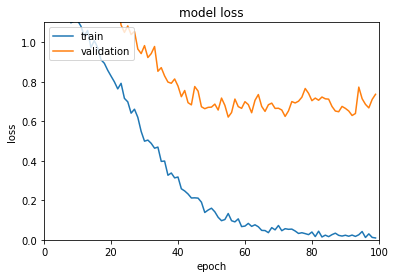

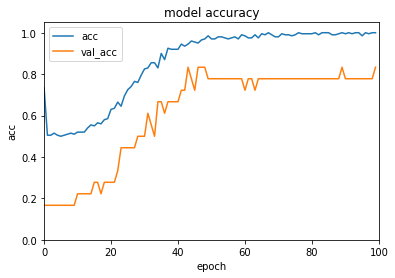

[[13  2]
 [ 1  2]]
PPV:  0.5
Recall:  0.6666666666666666


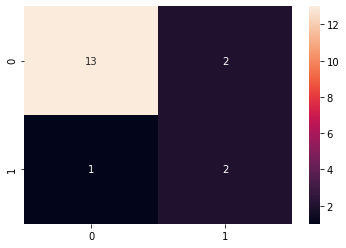

In [8]:
p0, t0 = run_model(0)

In [ ]:
p1, t1 = run_model(1)

COMET WARNING: Set model graph by 'keras' ignored; already called. Future attempts are silently ignored.


Train on 200 samples, validate on 17 samples
Epoch 1/100
200/200 [==============================] - 4s 19ms/step - loss: 1.8861 - acc: 0.7250 - val_loss: 4.0258 - val_acc: 0.1176
Epoch 2/100
200/200 [==============================] - 0s 606us/step - loss: 2.1534 - acc: 0.5050 - val_loss: 2.0954 - val_acc: 0.1176
Epoch 3/100
200/200 [==============================] - 0s 555us/step - loss: 1.6616 - acc: 0.4950 - val_loss: 1.3484 - val_acc: 0.1176
Epoch 4/100
200/200 [==============================] - 0s 454us/step - loss: 1.1962 - acc: 0.5050 - val_loss: 1.9154 - val_acc: 0.1176
Epoch 5/100
200/200 [==============================] - 0s 222us/step - loss: 1.2856 - acc: 0.5050 - val_loss: 1.9453 - val_acc: 0.1176
Epoch 6/100
200/200 [==============================] - 0s 923us/step - loss: 1.3121 - acc: 0.5050 - val_loss: 1.6229 - val_acc: 0.1176
Epoch 7/100
200/200 [==============================] - 0s 1ms/step - loss: 1.2485 - acc: 0.5150 - val_loss: 1.4665 - val_acc: 0.1176
Epoch 8/100
2

Epoch 43/100
200/200 [==============================] - 0s 1ms/step - loss: 0.1767 - acc: 0.9650 - val_loss: 0.7795 - val_acc: 0.7647
Epoch 44/100
200/200 [==============================] - 0s 1ms/step - loss: 0.1538 - acc: 0.9800 - val_loss: 0.8018 - val_acc: 0.7647
Epoch 45/100
200/200 [==============================] - 0s 2ms/step - loss: 0.1343 - acc: 0.9700 - val_loss: 0.8466 - val_acc: 0.7059
Epoch 46/100
200/200 [==============================] - 0s 1ms/step - loss: 0.1485 - acc: 0.9700 - val_loss: 0.8123 - val_acc: 0.7647
Epoch 47/100
200/200 [==============================] - 0s 1ms/step - loss: 0.1199 - acc: 0.9750 - val_loss: 0.8191 - val_acc: 0.7647
Epoch 48/100
200/200 [==============================] - 0s 1ms/step - loss: 0.1215 - acc: 0.9750 - val_loss: 0.8507 - val_acc: 0.7059
Epoch 49/100
200/200 [==============================] - 0s 2ms/step - loss: 0.1202 - acc: 0.9800 - val_loss: 0.8179 - val_acc: 0.7647
Epoch 50/100
200/200 [==============================] - ETA: 0

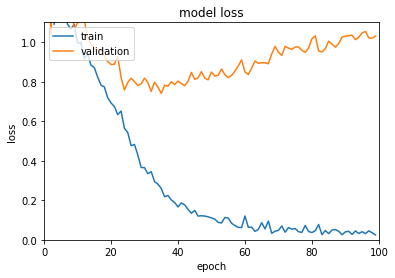

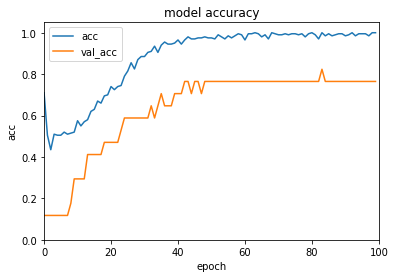

[[13  2]
 [ 2  0]]
PPV:  0.0
Recall:  0.0


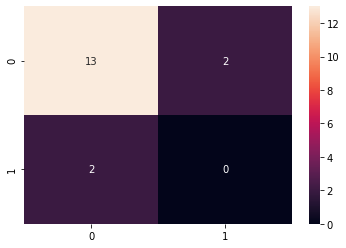

In [10]:
p2, t2 = run_model(2)

Train on 202 samples, validate on 17 samples
Epoch 1/100
202/202 [==============================] - 5s 24ms/step - loss: 2.0756 - acc: 0.7327 - val_loss: 4.3078 - val_acc: 0.1765
Epoch 2/100
202/202 [==============================] - 0s 1ms/step - loss: 2.5464 - acc: 0.5050 - val_loss: 2.0426 - val_acc: 0.1765
Epoch 3/100
202/202 [==============================] - 0s 718us/step - loss: 1.8569 - acc: 0.4554 - val_loss: 1.1324 - val_acc: 0.1765
Epoch 4/100
202/202 [==============================] - 0s 1ms/step - loss: 1.0904 - acc: 0.5297 - val_loss: 1.8913 - val_acc: 0.1765
Epoch 5/100
202/202 [==============================] - 0s 650us/step - loss: 1.3900 - acc: 0.5149 - val_loss: 1.8014 - val_acc: 0.1765
Epoch 6/100
202/202 [==============================] - 0s 634us/step - loss: 1.3429 - acc: 0.5099 - val_loss: 1.3589 - val_acc: 0.1765
Epoch 7/100
202/202 [==============================] - 0s 646us/step - loss: 1.2291 - acc: 0.5050 - val_loss: 1.3244 - val_acc: 0.1765
Epoch 8/100
202

202/202 [==============================] - 0s 1ms/step - loss: 0.0686 - acc: 0.9901 - val_loss: 0.5688 - val_acc: 0.7647
Epoch 62/100
202/202 [==============================] - 0s 2ms/step - loss: 0.0546 - acc: 0.9950 - val_loss: 0.5478 - val_acc: 0.8235
Epoch 63/100
202/202 [==============================] - 0s 1ms/step - loss: 0.0688 - acc: 0.9950 - val_loss: 0.5515 - val_acc: 0.8235
Epoch 64/100
202/202 [==============================] - 0s 2ms/step - loss: 0.0686 - acc: 0.9901 - val_loss: 0.5778 - val_acc: 0.7647
Epoch 65/100
202/202 [==============================] - 0s 1ms/step - loss: 0.0640 - acc: 0.9802 - val_loss: 0.5605 - val_acc: 0.8235
Epoch 66/100
202/202 [==============================] - 0s 2ms/step - loss: 0.0534 - acc: 1.0000 - val_loss: 0.5657 - val_acc: 0.8235
Epoch 67/100
202/202 [==============================] - 0s 2ms/step - loss: 0.0459 - acc: 1.0000 - val_loss: 0.5813 - val_acc: 0.7647
Epoch 68/100
202/202 [==============================] - 0s 1ms/step - loss:

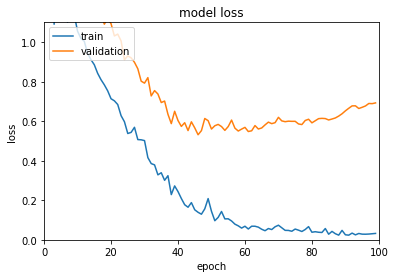

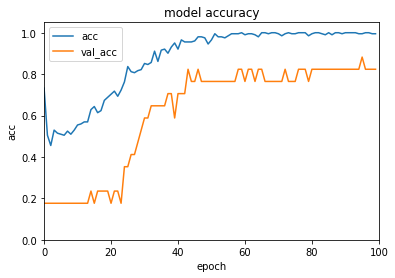

[[13  1]
 [ 2  1]]
PPV:  0.5
Recall:  0.3333333333333333


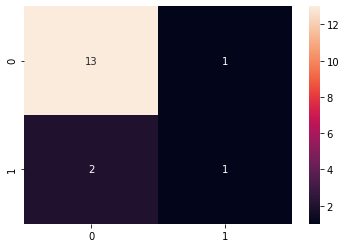

In [11]:
p3, t3 = run_model(3)

Train on 202 samples, validate on 17 samples
Epoch 1/100
202/202 [==============================] - 5s 25ms/step - loss: 2.0265 - acc: 0.7624 - val_loss: 4.1934 - val_acc: 0.1765
Epoch 2/100
202/202 [==============================] - 0s 1ms/step - loss: 2.4953 - acc: 0.5050 - val_loss: 2.5627 - val_acc: 0.1765
Epoch 3/100
202/202 [==============================] - 0s 1ms/step - loss: 1.9748 - acc: 0.4703 - val_loss: 1.1325 - val_acc: 0.1765
Epoch 4/100
202/202 [==============================] - 0s 1ms/step - loss: 1.1240 - acc: 0.5347 - val_loss: 1.7723 - val_acc: 0.1765
Epoch 5/100
202/202 [==============================] - 0s 1ms/step - loss: 1.3292 - acc: 0.5050 - val_loss: 1.7033 - val_acc: 0.1765
Epoch 6/100
202/202 [==============================] - 0s 1ms/step - loss: 1.3513 - acc: 0.5149 - val_loss: 1.3421 - val_acc: 0.1765
Epoch 7/100
202/202 [==============================] - 0s 2ms/step - loss: 1.2499 - acc: 0.5050 - val_loss: 1.2572 - val_acc: 0.1765
Epoch 8/100
202/202 [==

202/202 [==============================] - 0s 1ms/step - loss: 0.0929 - acc: 0.9851 - val_loss: 0.5614 - val_acc: 0.8235
Epoch 62/100
202/202 [==============================] - 0s 2ms/step - loss: 0.0905 - acc: 0.9851 - val_loss: 0.5653 - val_acc: 0.8235
Epoch 63/100
202/202 [==============================] - 0s 2ms/step - loss: 0.1138 - acc: 0.9703 - val_loss: 0.5329 - val_acc: 0.8235
Epoch 64/100
202/202 [==============================] - 0s 1ms/step - loss: 0.0864 - acc: 0.9851 - val_loss: 0.5927 - val_acc: 0.8235
Epoch 65/100
202/202 [==============================] - 0s 2ms/step - loss: 0.0929 - acc: 0.9752 - val_loss: 0.5788 - val_acc: 0.8235
Epoch 66/100
202/202 [==============================] - 0s 1ms/step - loss: 0.0597 - acc: 0.9950 - val_loss: 0.5688 - val_acc: 0.8235
Epoch 67/100
202/202 [==============================] - 0s 2ms/step - loss: 0.0892 - acc: 0.9851 - val_loss: 0.5560 - val_acc: 0.8235
Epoch 68/100
202/202 [==============================] - 0s 1ms/step - loss:

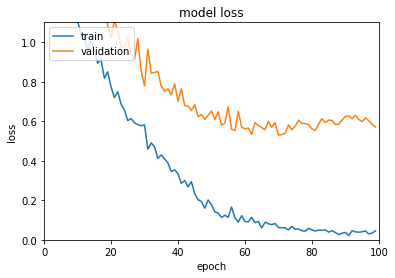

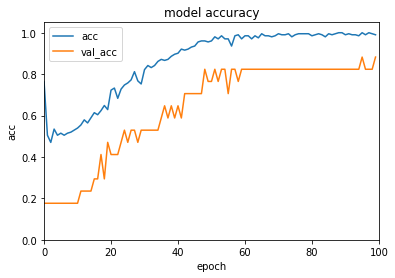

[[13  1]
 [ 1  2]]
PPV:  0.6666666666666666
Recall:  0.6666666666666666


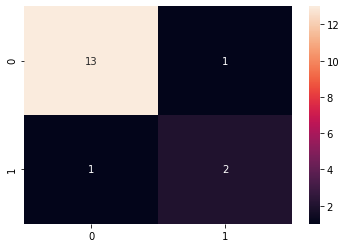

In [12]:
p4, t4 = run_model(4)

Train on 202 samples, validate on 17 samples
Epoch 1/100
202/202 [==============================] - 5s 26ms/step - loss: 2.3931 - acc: 0.7376 - val_loss: 3.3406 - val_acc: 0.2353
Epoch 2/100
202/202 [==============================] - 0s 504us/step - loss: 2.4764 - acc: 0.5000 - val_loss: 2.5366 - val_acc: 0.2353
Epoch 3/100
202/202 [==============================] - 0s 564us/step - loss: 1.7773 - acc: 0.5000 - val_loss: 1.2004 - val_acc: 0.2353
Epoch 4/100
202/202 [==============================] - 0s 796us/step - loss: 1.4000 - acc: 0.5050 - val_loss: 1.0760 - val_acc: 0.2353
Epoch 5/100
202/202 [==============================] - 0s 723us/step - loss: 1.2849 - acc: 0.5000 - val_loss: 1.2654 - val_acc: 0.2353
Epoch 6/100
202/202 [==============================] - 0s 579us/step - loss: 1.2532 - acc: 0.5000 - val_loss: 1.4411 - val_acc: 0.2353
Epoch 7/100
202/202 [==============================] - 0s 916us/step - loss: 1.3242 - acc: 0.5000 - val_loss: 1.4168 - val_acc: 0.2353
Epoch 8/100

C:\Users\mattbeze\Anaconda3\envs\tensorflow_env\lib\site-packages\keras\callbacks\callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.106325). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


202/202 [==============================] - 1s 3ms/step - loss: 0.1955 - acc: 0.9653 - val_loss: 0.6726 - val_acc: 0.7059
Epoch 57/100
202/202 [==============================] - 0s 1ms/step - loss: 0.2169 - acc: 0.9406 - val_loss: 0.6371 - val_acc: 0.7059
Epoch 58/100
202/202 [==============================] - 0s 1ms/step - loss: 0.2071 - acc: 0.9406 - val_loss: 0.6233 - val_acc: 0.7059
Epoch 59/100
202/202 [==============================] - 0s 1ms/step - loss: 0.2420 - acc: 0.9356 - val_loss: 0.7237 - val_acc: 0.7059
Epoch 60/100
202/202 [==============================] - 0s 1ms/step - loss: 0.2081 - acc: 0.9505 - val_loss: 0.6593 - val_acc: 0.7059
Epoch 61/100
202/202 [==============================] - 0s 1ms/step - loss: 0.1747 - acc: 0.9604 - val_loss: 0.5822 - val_acc: 0.7647
Epoch 62/100
202/202 [==============================] - 0s 1ms/step - loss: 0.1457 - acc: 0.9752 - val_loss: 0.6286 - val_acc: 0.7059
Epoch 63/100
202/202 [==============================] - 0s 913us/step - los

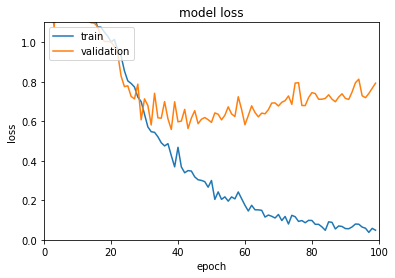

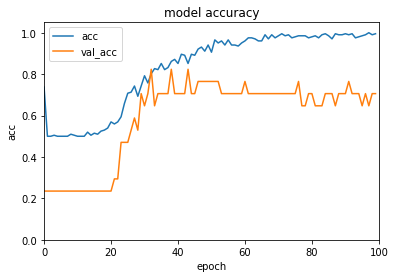

[[11  3]
 [ 2  1]]
PPV:  0.25
Recall:  0.3333333333333333


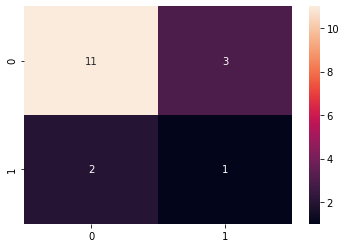

In [13]:
p5, t5 = run_model(5)

Train on 202 samples, validate on 17 samples
Epoch 1/100
202/202 [==============================] - 5s 24ms/step - loss: 2.1323 - acc: 0.7525 - val_loss: 3.3865 - val_acc: 0.1765
Epoch 2/100
202/202 [==============================] - 0s 712us/step - loss: 2.3540 - acc: 0.5050 - val_loss: 2.1086 - val_acc: 0.1765
Epoch 3/100
202/202 [==============================] - 0s 1ms/step - loss: 1.8348 - acc: 0.4901 - val_loss: 1.0119 - val_acc: 0.1765
Epoch 4/100
202/202 [==============================] - 0s 503us/step - loss: 1.1704 - acc: 0.5198 - val_loss: 1.4117 - val_acc: 0.1765
Epoch 5/100
202/202 [==============================] - 0s 623us/step - loss: 1.2438 - acc: 0.5050 - val_loss: 1.4849 - val_acc: 0.1765
Epoch 6/100
202/202 [==============================] - 0s 1ms/step - loss: 1.2676 - acc: 0.5149 - val_loss: 1.2905 - val_acc: 0.1765
Epoch 7/100
202/202 [==============================] - 0s 642us/step - loss: 1.2567 - acc: 0.5149 - val_loss: 1.1765 - val_acc: 0.1765
Epoch 8/100
202

202/202 [==============================] - 0s 1ms/step - loss: 0.0819 - acc: 0.9901 - val_loss: 0.4467 - val_acc: 0.8235
Epoch 62/100
202/202 [==============================] - 0s 878us/step - loss: 0.0708 - acc: 0.9950 - val_loss: 0.4165 - val_acc: 0.8235
Epoch 63/100
202/202 [==============================] - 0s 2ms/step - loss: 0.0678 - acc: 0.9901 - val_loss: 0.4396 - val_acc: 0.8235
Epoch 64/100
202/202 [==============================] - 0s 1ms/step - loss: 0.0603 - acc: 0.9901 - val_loss: 0.4771 - val_acc: 0.8235
Epoch 65/100
202/202 [==============================] - 0s 1ms/step - loss: 0.0548 - acc: 0.9901 - val_loss: 0.4492 - val_acc: 0.8235
Epoch 66/100
202/202 [==============================] - 0s 2ms/step - loss: 0.0801 - acc: 0.9851 - val_loss: 0.4011 - val_acc: 0.8235
Epoch 67/100
202/202 [==============================] - 0s 1ms/step - loss: 0.0610 - acc: 0.9851 - val_loss: 0.4584 - val_acc: 0.8235
Epoch 68/100
202/202 [==============================] - 0s 1ms/step - los

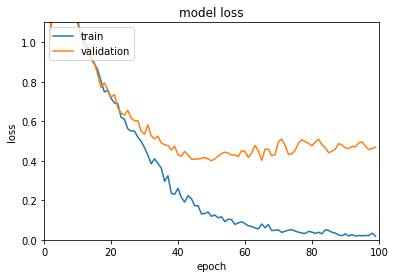

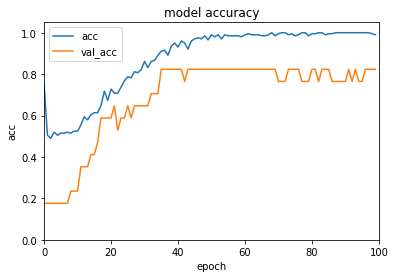

[[13  1]
 [ 2  1]]
PPV:  0.5
Recall:  0.3333333333333333


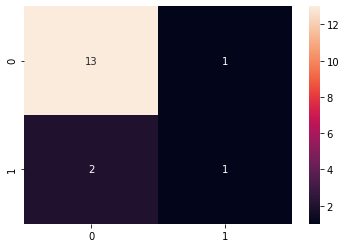

In [14]:
p6, t6 = run_model(6)

Train on 202 samples, validate on 17 samples
Epoch 1/100
202/202 [==============================] - 5s 24ms/step - loss: 2.2863 - acc: 0.7327 - val_loss: 3.9988 - val_acc: 0.1765
Epoch 2/100
202/202 [==============================] - 0s 1ms/step - loss: 2.6161 - acc: 0.5000 - val_loss: 2.2812 - val_acc: 0.1765
Epoch 3/100
202/202 [==============================] - 0s 789us/step - loss: 1.9971 - acc: 0.4653 - val_loss: 1.1075 - val_acc: 0.1765
Epoch 4/100
202/202 [==============================] - 0s 690us/step - loss: 1.1988 - acc: 0.5149 - val_loss: 1.6362 - val_acc: 0.1765
Epoch 5/100
202/202 [==============================] - 0s 1ms/step - loss: 1.3825 - acc: 0.5050 - val_loss: 1.6136 - val_acc: 0.1765
Epoch 6/100
202/202 [==============================] - 0s 1ms/step - loss: 1.3458 - acc: 0.5050 - val_loss: 1.3512 - val_acc: 0.1765
Epoch 7/100
202/202 [==============================] - 0s 760us/step - loss: 1.3539 - acc: 0.5050 - val_loss: 1.2529 - val_acc: 0.1765
Epoch 8/100
202/2

202/202 [==============================] - 0s 1ms/step - loss: 0.1078 - acc: 0.9802 - val_loss: 0.2369 - val_acc: 0.8824
Epoch 62/100
202/202 [==============================] - 0s 1ms/step - loss: 0.1415 - acc: 0.9505 - val_loss: 0.2738 - val_acc: 0.8824
Epoch 63/100
202/202 [==============================] - 0s 2ms/step - loss: 0.1504 - acc: 0.9505 - val_loss: 0.2590 - val_acc: 0.8824
Epoch 64/100
202/202 [==============================] - 0s 1ms/step - loss: 0.1558 - acc: 0.9554 - val_loss: 0.2708 - val_acc: 0.8824
Epoch 65/100
202/202 [==============================] - 0s 2ms/step - loss: 0.1230 - acc: 0.9703 - val_loss: 0.2379 - val_acc: 0.8824
Epoch 66/100
202/202 [==============================] - 0s 2ms/step - loss: 0.0988 - acc: 0.9752 - val_loss: 0.2251 - val_acc: 0.8824
Epoch 67/100
202/202 [==============================] - 0s 2ms/step - loss: 0.0883 - acc: 0.9802 - val_loss: 0.2382 - val_acc: 0.8824
Epoch 68/100
202/202 [==============================] - 0s 1ms/step - loss:

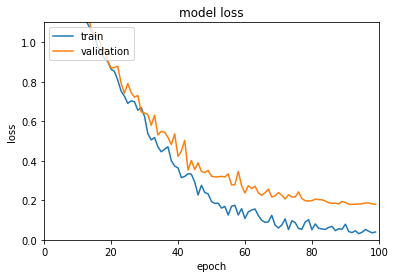

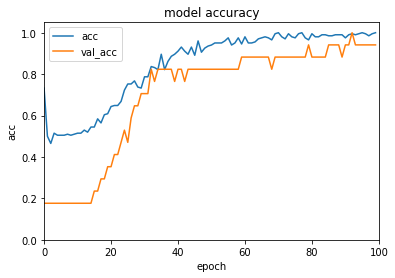

[[13  1]
 [ 0  3]]
PPV:  0.75
Recall:  1.0


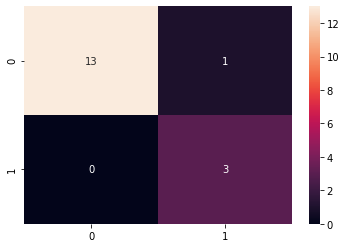

In [15]:
p7, t7 = run_model(7)

Positive Predictive Value tp/(tp+fp):  0.43478260869565216
Recall Value tp/(tp+fn):  0.45454545454545453
[[102  13]
 [ 12  10]]


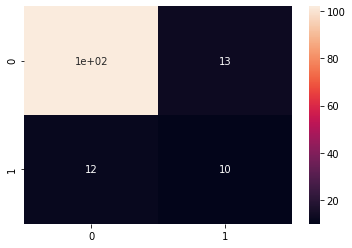

In [16]:
create_summary_matrix(p0, p1, p2, p3, p4, p5, p6, p7, t0, t1, t2, t3, t4, t5, t6, t7)